### Library Imports and Definitions

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

In [90]:
def plot_eda(df, column_name, bins=30):
    """
    Plots side-by-side:
      1. A histogram of values in 'column_name'
      2. A line chart of the time series for 'column_name'
    
    Parameters:
      df (pandas.DataFrame): DataFrame with a DateTimeIndex
      column_name (str): Name of the column to plot
      bins (int): Number of bins to use in the histogram
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    
    # Histogram
    axes[0].hist(df[column_name].dropna(), bins=bins)
    axes[0].set_title(f"Distribution of {column_name}")
    axes[0].set_xlabel("Value")
    axes[0].set_ylabel("Frequency")
    
    # Time series line plot
    axes[1].plot(df.index, df[column_name])
    axes[1].set_title(f"Time Series of {column_name}")
    axes[1].set_xlabel("Date")
    axes[1].set_ylabel("Value")
    
    plt.tight_layout()
    plt.show()

### Weather Data


Weather data comes in an excel will all the data in one column with what seams to be comma separated values. We are going to read and save properly the data. 

In [91]:
## Let's read the Excel without any header
raw_weather = pd.read_excel('data/raw/Meteorologia.xlsx', header=None)
# We are going to extract the columns
raw_weather_columns = raw_weather.iloc[0,0]
raw_weather_columns = raw_weather_columns.split(',')
# Then we are going to separate the values using the commas
raw_weather_data = raw_weather.iloc[1:,:]
raw_weather_data = raw_weather_data[0].str.split(',', expand=True)
raw_weather_data.columns= raw_weather_columns
# Now that we have the data we are going to parse properly the date
raw_weather_data['date'] = pd.to_datetime(raw_weather_data['FORECAST_TIMESTAMP'])
weather_data = raw_weather_data.set_index('date').drop(columns='FORECAST_TIMESTAMP')
# Let's clear space in memory
del raw_weather_data
del raw_weather
for column in weather_data.columns:
    weather_data[column] = pd.to_numeric(weather_data[column])
weather_data.to_csv('data/raw/weather_data.csv')

Now that we have our clean data, we are going to filter down to the 4 closest weather stations so we can have our estimated weather data for our industry in Pinto. 

In [92]:
weather_data['coordinates'] = list(zip(weather_data['LATITUDE'], weather_data['LONGITUDE']))
coordinates = weather_data['coordinates'].unique()
coordinates = pd.DataFrame(coordinates, columns=['coordinates'])
coordinates

,coordinates
0,"(40.0, -4.0)"
1,"(40.0, -3.75)"
2,"(40.0, -3.5)"
3,"(40.25, -4.0)"
4,"(40.25, -3.75)"
5,"(40.25, -3.5)"
6,"(40.5, -4.0)"
7,"(40.5, -3.75)"
8,"(40.5, -3.5)"


Let's define the function to get the distance from Pinto so we can then get the 4 nearest stations. This is sort of a manual knn filling of the data.

In [93]:
import math
def euclidean_distance_pinto(tuple1):
    lat_lon_pinto = (40.2375, -3.6968)
    distance = math.sqrt((lat_lon_pinto[0] - tuple1[0])**2 + (lat_lon_pinto[1] - tuple1[1])**2)
    return distance

coordinates['distance'] = coordinates.apply(lambda row: euclidean_distance_pinto(row['coordinates']),axis=1)
coordinates.head()

,coordinates,distance
0,"(40.0, -4.0)",0.385145
1,"(40.0, -3.75)",0.243385
2,"(40.0, -3.5)",0.308442
3,"(40.25, -4.0)",0.303458
4,"(40.25, -3.75)",0.054649


In [94]:
included_stations = coordinates.sort_values('distance', ascending=True).reset_index().loc[:3,'coordinates']
included_stations = included_stations.to_list()
included_stations

[(40.25, -3.75), (40.25, -3.5), (40.0, -3.75), (40.5, -3.75)]

In [95]:
weather_data = weather_data[weather_data['coordinates'].isin(included_stations)]
weather_data.head()

,LATITUDE,LONGITUDE,10uheightAboveGround_10,10vheightAboveGround_10,2rheightAboveGround_2,2shheightAboveGround_2,2theightAboveGround_2,SUNSDsurface_0,aptmpheightAboveGround_2,dlwrfsurface_0,...,tccatmosphere_0,theightAboveGround_80,tmaxheightAboveGround_2,tminheightAboveGround_2,tozneatmosphereSingleLayer_0,tpsurface_0,tsurface_0,uheightAboveGround_80,vheightAboveGround_80,coordinates
date,,,,,,,,,,,,,,,,,,,,,
2023-07-24 11:00:00+00:00,40.0,-3.75,6.629717,1.254463,17.5,0.004574,301.767859,18000.0,300.344031,319.80769,...,0.0,299.078662,301.832129,292.501489,322.706396,0.0,316.600012,7.379102,1.483457,"(40.0, -3.75)"
2023-07-24 12:00:00+00:00,40.0,-3.75,7.186357,1.511797,17.3,0.004918,303.265576,21600.0,301.370923,323.60769,...,0.0,300.400000,303.263452,292.501489,323.303369,0.0,318.500000,8.081675,1.803066,"(40.0, -3.75)"
2023-07-24 13:00:00+00:00,40.0,-3.75,7.806143,1.284370,17.1,0.005276,304.654614,3600.0,302.603198,353.40000,...,60.2,301.895581,304.615100,303.200000,324.496606,0.0,319.577295,8.977305,1.582959,"(40.0, -3.75)"
2023-07-24 14:00:00+00:00,40.0,-3.75,9.322205,0.843123,17.0,0.005565,305.581506,7200.0,303.444031,359.14873,...,5.0,302.944043,305.589685,303.200000,326.790967,0.0,318.415942,10.752161,1.211703,"(40.0, -3.75)"
2023-07-24 15:00:00+00:00,40.0,-3.75,9.707048,1.075879,17.2,0.005734,306.076172,10800.0,303.834607,362.30000,...,5.0,303.632275,306.095581,303.200000,328.955933,0.0,316.835266,11.256921,1.411133,"(40.0, -3.75)"


In [96]:
### Let's average out the closest stations data to have our model data for Pinto
weather_data = weather_data.drop(columns=['LATITUDE', 'LONGITUDE', 'coordinates'])
weather_data_grouped = weather_data.groupby(weather_data.index, dropna=True).mean()
weather_data = weather_data_grouped

now let's localize our weather data in our Madrid timezone so we can use it later in our analysis

In [97]:
print(weather_data.index.tz)
weather_data.index = weather_data.index.tz_convert('Europe/Madrid')
print(weather_data.index.tz)

UTC
Europe/Madrid


In [138]:
weather_data.head()

,10uheightAboveGround_10,10vheightAboveGround_10,2rheightAboveGround_2,2shheightAboveGround_2,2theightAboveGround_2,SUNSDsurface_0,aptmpheightAboveGround_2,dlwrfsurface_0,dswrfsurface_0,gustsurface_0,...,spsurface_0,tccatmosphere_0,theightAboveGround_80,tmaxheightAboveGround_2,tminheightAboveGround_2,tozneatmosphereSingleLayer_0,tpsurface_0,tsurface_0,uheightAboveGround_80,vheightAboveGround_80
date,,,,,,,,,,,,,,,,,,,,,
2023-07-24 13:00:00+02:00,5.552217,2.449463,17.100,0.004546,301.942859,18000.0,300.419031,320.40769,570.110,7.175171,...,94113.453125,2.175,299.228662,301.957129,293.601489,324.606396,0.0,314.950012,6.439102,2.633457
2023-07-24 14:00:00+02:00,5.856357,3.034297,16.850,0.004803,303.165576,21600.0,301.320923,323.98269,635.764,8.005784,...,94057.793750,2.175,300.400000,303.213452,293.601489,325.278369,0.0,316.800000,6.899175,3.333066
2023-07-24 15:00:00+02:00,6.528643,3.126870,16.650,0.005111,304.404614,3600.0,302.353198,351.37500,980.375,8.903244,...,93990.868750,54.200,301.595581,304.390100,303.200000,326.146606,0.0,317.627295,7.832305,3.467959
2023-07-24 16:00:00+02:00,7.584705,2.043123,17.275,0.005530,305.131506,7200.0,302.994031,355.97373,956.795,9.585358,...,93937.159375,18.350,302.369043,305.164685,303.200000,327.115967,0.0,316.915942,9.052161,2.211703
2023-07-24 17:00:00+02:00,7.519548,2.373379,17.225,0.005634,305.551172,10800.0,303.409607,359.47500,916.180,9.929451,...,93880.075000,46.025,303.057275,305.595581,303.200000,330.280933,0.0,315.610266,8.981921,2.736133


In [98]:
weather_data.to_csv('data/processed/weather_data.csv')

### Solar generation

In [117]:
### Generación fotovoltaica. Date and Times are already in Madrid Local/Time.
solar_gen = pd.read_csv('data/raw/Generacion_fotovoltaica.csv')
solar_gen['datetime'] = pd.to_datetime(solar_gen['FECHA'])
solar_gen = solar_gen.set_index('datetime').drop(columns=['FECHA']).rename(columns={'TOTAL_KWH_ENERGIA': 'solar_gen_kwh'})
print(solar_gen.dtypes)
print(solar_gen.head())
print("\nNull Values: ",solar_gen.isna().sum())
solar_gen.describe()

solar_gen_kwh    float64
dtype: object
                     solar_gen_kwh
datetime                          
2023-07-24 11:00:00            NaN
2023-07-24 12:00:00         115.66
2023-07-24 13:00:00         129.98
2023-07-24 14:00:00         134.35
2023-07-24 15:00:00         133.90

Null Values:  solar_gen_kwh    1164
dtype: int64


,solar_gen_kwh
count,8544.000000
mean,25.395279
std,40.258814
min,-0.150000
25%,0.000000
50%,0.990000
75%,32.635000
max,153.050000


In [140]:
solar_gen['day_of_week'] = solar_gen.index.day_of_week
solar_gen['hour'] = solar_gen.index.hour
hourly_avg = solar_gen.groupby(solar_gen.index.hour)['solar_gen_kwh'].mean()
hourly_avg

C:\Users\RUA\AppData\Local\Temp\ipykernel_29612\1956527365.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_gen['day_of_week'] = solar_gen.index.day_of_week
C:\Users\RUA\AppData\Local\Temp\ipykernel_29612\1956527365.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_gen['hour'] = solar_gen.index.hour


datetime
0      0.002772
1     -0.003119
2      0.000000
3      0.000000
4      0.000000
5      0.000000
6      0.000000
7      0.023549
8      1.183267
9      7.760632
10    28.695621
11    50.621836
12    69.027119
13    78.345480
14    80.106723
15    76.471158
16    71.214479
17    60.665686
18    44.756648
19    26.658156
20    12.578520
21     2.978687
22     0.285475
23    -0.004914
Name: solar_gen_kwh, dtype: float64

Let's fill nulls during the night with a 0. It will not harm the dataset too much.

In [141]:
solar_gen[(solar_gen['solar_gen_kwh'].isna()) & (solar_gen['hour'].isin([23,0,1,2,3,4,5,6]))] = 0
solar_gen.isna().sum()

C:\Users\RUA\AppData\Local\Temp\ipykernel_29612\3933528162.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_gen[(solar_gen['solar_gen_kwh'].isna()) & (solar_gen['hour'].isin([23,0,1,2,3,4,5,6]))] = 0


solar_gen_kwh         795
day_of_week             0
hour                    0
working_day             0
date                    0
h_from_max              0
days_from_solstice      0
dtype: int64

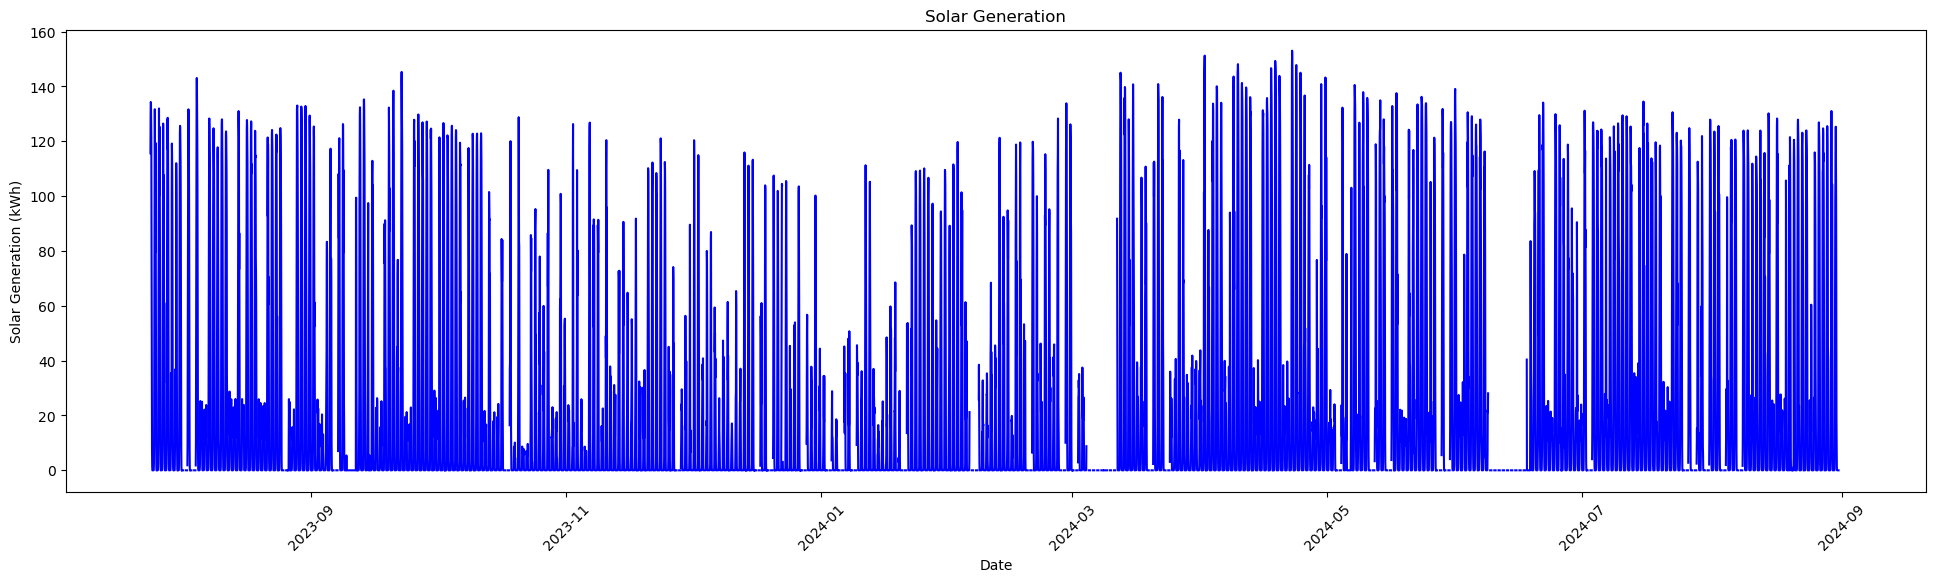

In [122]:
plt.figure(figsize=(24,6))
plt.plot(solar_gen['solar_gen_kwh'], color = "blue")
plt.ylabel('Solar Generation (kWh)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Solar Generation")
plt.show()

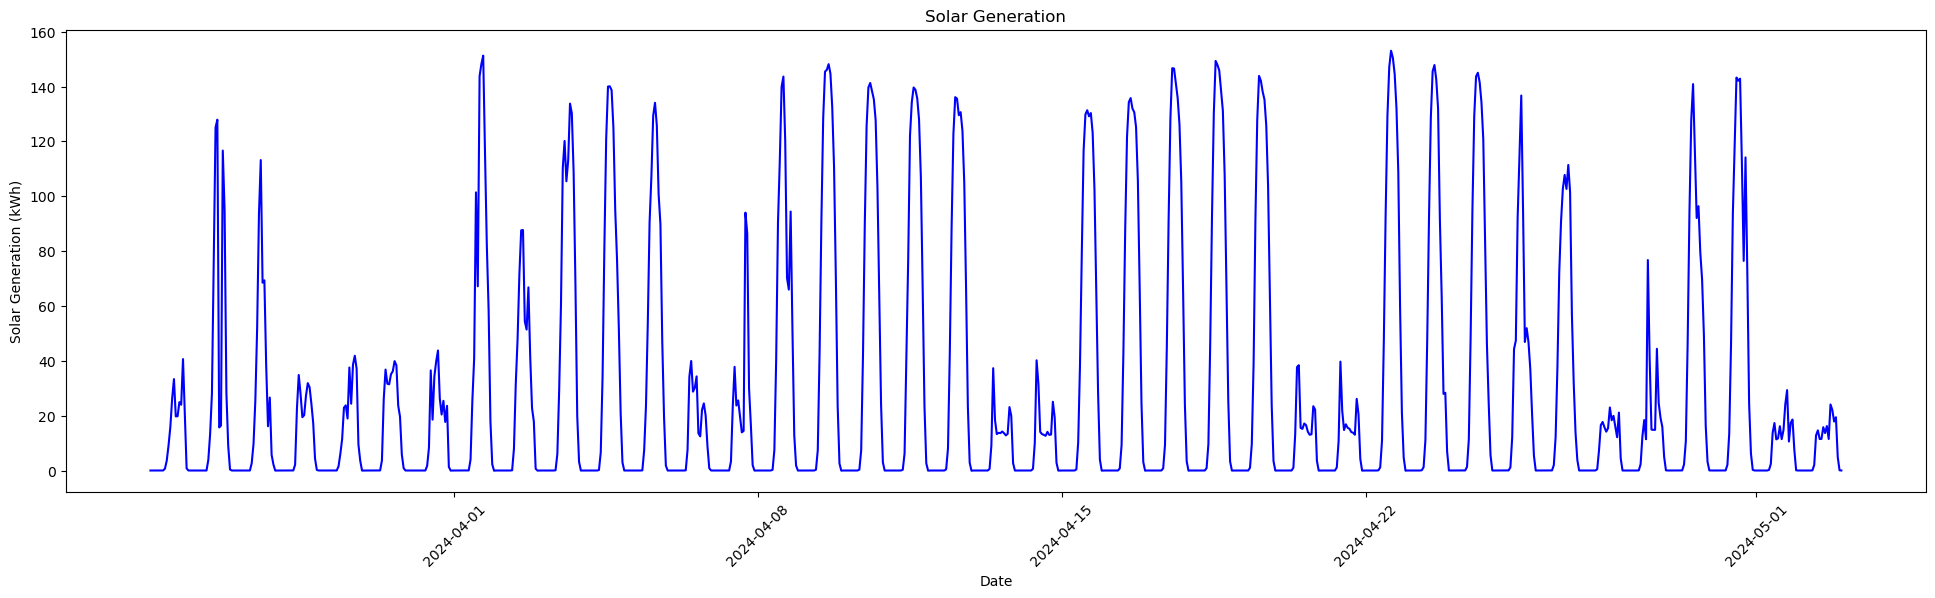

In [123]:
plt.figure(figsize=(24,6))
plt.plot(solar_gen['solar_gen_kwh']['2024-03-25':'2024-05-02'], color = "blue")
plt.ylabel('Solar Generation (kWh)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Solar Generation")
plt.show()

<Figure size 800x500 with 0 Axes>

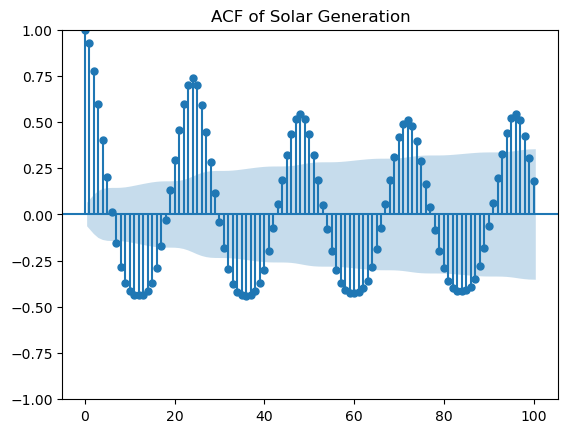

In [124]:
from statsmodels.graphics.tsaplots import plot_acf

solar_gen_subset = solar_gen['2024-03-25':'2024-05-02']

# Plot ACF of Apple closing prices
plt.figure(figsize=(8, 5))
plot_acf(solar_gen_subset['solar_gen_kwh'], lags=100)
plt.title("ACF of Solar Generation")
plt.show()

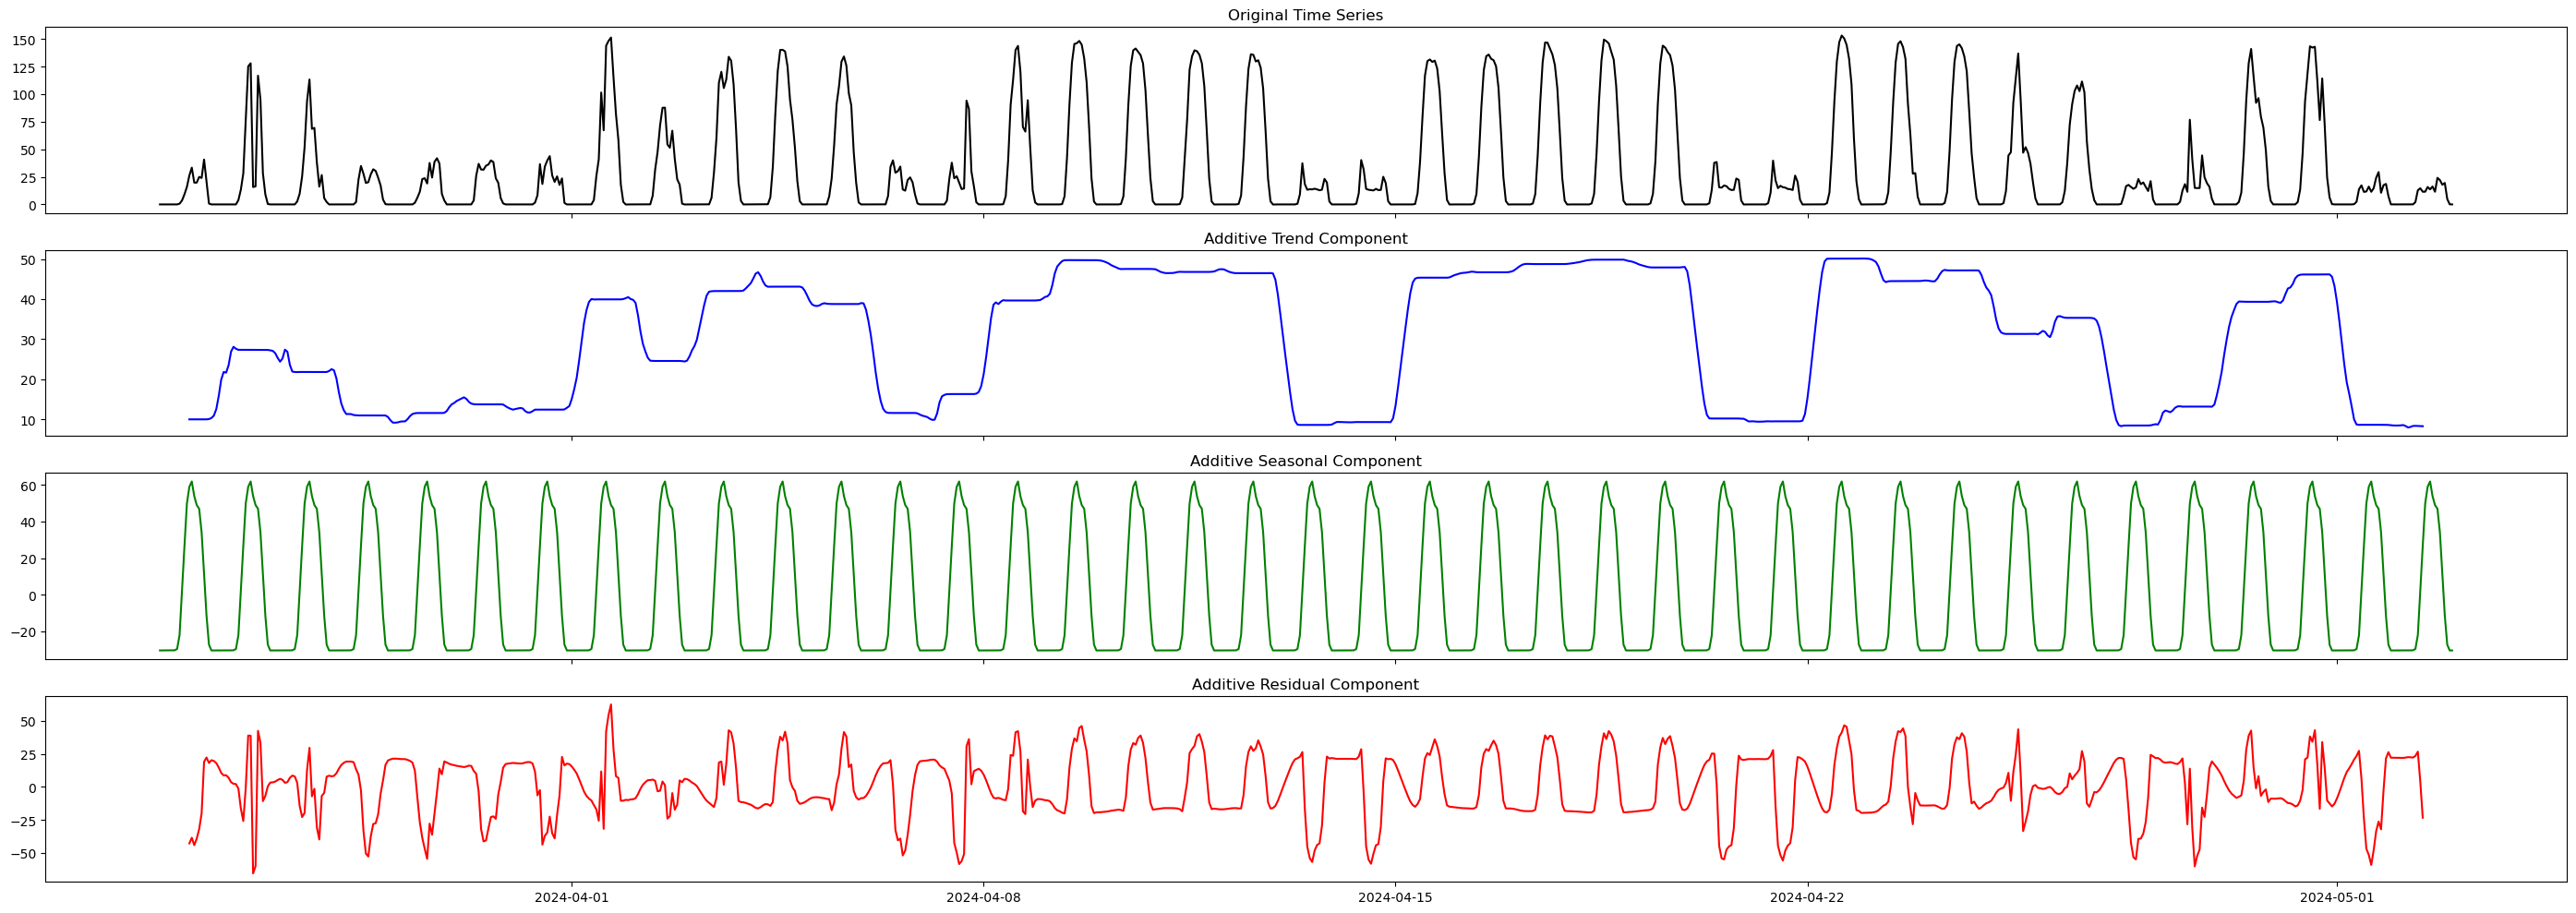

In [125]:

# ---  Apply Additive and Multiplicative Decomposition ---
additive_decomposition = seasonal_decompose(solar_gen_subset['solar_gen_kwh'], model="additive", period=24)


# Plot both decompositions side by side
fig, axes = plt.subplots(4, 1, figsize=(28, 10), sharex=True)

# Additive Decomposition Plots
axes[0].plot(solar_gen_subset.index, solar_gen_subset['solar_gen_kwh'], color="black")
axes[0].set_title("Original Time Series")

axes[1].plot(solar_gen_subset.index, additive_decomposition.trend, color="blue")
axes[1].set_title("Additive Trend Component")

axes[2].plot(solar_gen_subset.index, additive_decomposition.seasonal, color="green")
axes[2].set_title("Additive Seasonal Component")

axes[3].plot(solar_gen_subset.index, additive_decomposition.resid, color="red")
axes[3].set_title("Additive Residual Component")

plt.tight_layout()
plt.show()

Let's localize our Naive time in Madrid and assign NAT to the conflictive values. As they happen during the night we will fill the solar generation with zeros

In [126]:
solar_gen.index = solar_gen.index.tz_localize('Europe/Madrid', ambiguous='NaT', nonexistent='shift_forward')
solar_gen = solar_gen[~solar_gen.index.isna()]
solar_gen.describe()

,solar_gen_kwh,day_of_week,hour
count,8912.000000,9707.000000,9707.000000
mean,24.346640,2.877923,11.298444
std,39.741318,2.041107,7.051607
min,-0.150000,0.000000,0.000000
25%,0.000000,1.000000,5.000000
50%,0.220000,3.000000,11.000000
75%,29.365000,5.000000,17.000000
max,153.050000,6.000000,23.000000


In [127]:
weekly_avg = solar_gen.groupby(solar_gen.index.day_of_week)['solar_gen_kwh'].mean()
weekly_avg

datetime
0    28.954021
1    29.383766
2    29.729002
3    27.006725
4    31.457053
5    11.298975
6    12.625455
Name: solar_gen_kwh, dtype: float64

Note that on holidays such as Easter and "Puente de Mayo" the solar generation drops, so we are going to treat them as if they were weekends

In [128]:
import holidays
madrid_holidays = holidays.Spain(subdiv='MD', years=range(2023, 2025))

In [129]:
madrid_holidays.keys

<function Spain.keys>

In [130]:
solar_gen['working_day'] = (solar_gen['day_of_week'] < 5).astype(int)
solar_gen['date'] = solar_gen.index.date
solar_gen['working_day'] = solar_gen.apply(lambda row: 0 if row['date'] in madrid_holidays else row['working_day'], axis=1)
solar_gen['2024-04-30':'2024-05-02'].head(50)

C:\Users\RUA\AppData\Local\Temp\ipykernel_29612\2469075836.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_gen['working_day'] = (solar_gen['day_of_week'] < 5).astype(int)
C:\Users\RUA\AppData\Local\Temp\ipykernel_29612\2469075836.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_gen['date'] = solar_gen.index.date
C:\Users\RUA\AppData\Local\Temp\ipykernel_29612\2469075836.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

,solar_gen_kwh,day_of_week,hour,working_day,date
datetime,,,,,
2024-04-30 00:00:00+02:00,0.00,1,0,1,2024-04-30
2024-04-30 01:00:00+02:00,0.00,1,1,1,2024-04-30
2024-04-30 02:00:00+02:00,0.00,1,2,1,2024-04-30
2024-04-30 03:00:00+02:00,0.00,1,3,1,2024-04-30
2024-04-30 04:00:00+02:00,0.00,1,4,1,2024-04-30
2024-04-30 05:00:00+02:00,0.00,1,5,1,2024-04-30
2024-04-30 06:00:00+02:00,0.00,1,6,1,2024-04-30
2024-04-30 07:00:00+02:00,0.02,1,7,1,2024-04-30
2024-04-30 08:00:00+02:00,2.09,1,8,1,2024-04-30


Now there is a clear seasonal component but it is not linear so we are going to try a different approach. As there are two seasonalities, we are going to try and use our local daily maximum as a base point and create and hours_from_maximum field that can encode that daily variability properly. Furthermore, we can expand this idea to the year and have the summer solstice as a base point. 

In [135]:
peak_hr = 14

def hours_to_closest_peak(hour):
    difference = abs(hour - peak_hr)
    return min(difference, 24 - difference)

hours_to_closest_peak(2)

solar_gen['h_from_max'] = solar_gen.apply(lambda row: hours_to_closest_peak(row['hour']), axis=1)
solar_gen.head()

C:\Users\RUA\AppData\Local\Temp\ipykernel_29612\3561634929.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_gen['h_from_max'] = solar_gen.apply(lambda row: hours_to_closest_peak(row['hour']), axis=1)


,solar_gen_kwh,day_of_week,hour,working_day,date,h_from_max
datetime,,,,,,
2023-07-24 11:00:00+02:00,NaN,0,11,1,2023-07-24,3
2023-07-24 12:00:00+02:00,115.66,0,12,1,2023-07-24,2
2023-07-24 13:00:00+02:00,129.98,0,13,1,2023-07-24,1
2023-07-24 14:00:00+02:00,134.35,0,14,1,2023-07-24,0
2023-07-24 15:00:00+02:00,133.90,0,15,1,2023-07-24,1


In [137]:
def days_to_closest_summer_solstice(date: pd.Timestamp) -> int:
    # Ensure the input date is timezone-naive
    date = date.tz_localize(None)

    year = date.year
    solstices = [
        pd.Timestamp(f"{year - 1}-06-21"),
        pd.Timestamp(f"{year}-06-21"),
        pd.Timestamp(f"{year + 1}-06-21"),
    ]
    
    differences = [abs((date - solstice).days) for solstice in solstices]
    return min(differences)

solar_gen['days_from_solstice'] = solar_gen.index.to_series().apply(days_to_closest_summer_solstice)
solar_gen.head()

C:\Users\RUA\AppData\Local\Temp\ipykernel_29612\708983755.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_gen['days_from_solstice'] = solar_gen.index.to_series().apply(days_to_closest_summer_solstice)


,solar_gen_kwh,day_of_week,hour,working_day,date,h_from_max,days_from_solstice
datetime,,,,,,,
2023-07-24 11:00:00+02:00,NaN,0,11,1,2023-07-24,3,33
2023-07-24 12:00:00+02:00,115.66,0,12,1,2023-07-24,2,33
2023-07-24 13:00:00+02:00,129.98,0,13,1,2023-07-24,1,33
2023-07-24 14:00:00+02:00,134.35,0,14,1,2023-07-24,0,33
2023-07-24 15:00:00+02:00,133.90,0,15,1,2023-07-24,1,33


Now we can merge the solar_gen and the weather_data dataframes to start analyzing the solar generation.

In [152]:
solar_weather = pd.merge(solar_gen, weather_data, how='inner', left_index=True, right_index=True)
solar_weather

,solar_gen_kwh,day_of_week,hour,working_day,date,h_from_max,days_from_solstice,10uheightAboveGround_10,10vheightAboveGround_10,2rheightAboveGround_2,...,spsurface_0,tccatmosphere_0,theightAboveGround_80,tmaxheightAboveGround_2,tminheightAboveGround_2,tozneatmosphereSingleLayer_0,tpsurface_0,tsurface_0,uheightAboveGround_80,vheightAboveGround_80
2023-07-24 13:00:00+02:00,129.98,0,13,1,2023-07-24,1,33,5.552217,2.449463,17.100,...,94113.453125,2.175,299.228662,301.957129,293.601489,324.606396,0.000000,314.950012,6.439102,2.633457
2023-07-24 14:00:00+02:00,134.35,0,14,1,2023-07-24,0,33,5.856357,3.034297,16.850,...,94057.793750,2.175,300.400000,303.213452,293.601489,325.278369,0.000000,316.800000,6.899175,3.333066
2023-07-24 15:00:00+02:00,133.90,0,15,1,2023-07-24,1,33,6.528643,3.126870,16.650,...,93990.868750,54.200,301.595581,304.390100,303.200000,326.146606,0.000000,317.627295,7.832305,3.467959
2023-07-24 16:00:00+02:00,126.93,0,16,1,2023-07-24,2,33,7.584705,2.043123,17.275,...,93937.159375,18.350,302.369043,305.164685,303.200000,327.115967,0.000000,316.915942,9.052161,2.211703
2023-07-24 17:00:00+02:00,121.22,0,17,1,2023-07-24,3,33,7.519548,2.373379,17.225,...,93880.075000,46.025,303.057275,305.595581,303.200000,330.280933,0.000000,315.610266,8.981921,2.736133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31 19:00:00+02:00,NaN,5,19,0,2024-08-31,5,71,1.973801,1.823562,40.900,...,94141.368750,98.275,301.075000,302.820093,299.638428,302.262988,0.250000,303.493311,2.525242,2.294253
2024-08-31 20:00:00+02:00,NaN,5,20,0,2024-08-31,6,71,0.700432,1.862703,44.800,...,94119.668750,47.900,300.334033,302.820093,299.188428,301.972119,0.406250,301.252832,1.310281,2.537390
2024-08-31 21:00:00+02:00,NaN,5,21,0,2024-08-31,7,71,1.102878,1.121714,49.600,...,94145.068750,13.225,300.003540,300.993335,299.765186,303.260889,0.031250,299.074316,2.017695,1.560337
2024-08-31 22:00:00+02:00,NaN,5,22,0,2024-08-31,8,71,0.578440,0.726792,51.425,...,94168.065625,99.200,299.658203,300.965186,299.345117,304.266699,0.046875,298.475000,1.210718,0.945347


In [153]:
solar_weather.drop(columns='date', inplace=True)
solar_weather.corr()

,solar_gen_kwh,day_of_week,hour,working_day,h_from_max,days_from_solstice,10uheightAboveGround_10,10vheightAboveGround_10,2rheightAboveGround_2,2shheightAboveGround_2,...,spsurface_0,tccatmosphere_0,theightAboveGround_80,tmaxheightAboveGround_2,tminheightAboveGround_2,tozneatmosphereSingleLayer_0,tpsurface_0,tsurface_0,uheightAboveGround_80,vheightAboveGround_80
solar_gen_kwh,1.000000,-0.149007,0.279988,0.205397,-0.695540,-0.167964,0.061439,0.046190,-0.400777,-0.066207,...,0.026384,-0.124815,0.265955,0.256844,0.206082,0.032616,-0.082617,0.582708,0.028465,0.034140
day_of_week,-0.149007,1.000000,-0.001173,-0.718004,0.000013,0.002633,-0.011936,0.052682,-0.016252,-0.013709,...,-0.054944,0.020955,0.003470,0.001477,0.000987,0.012337,0.034806,-0.008901,-0.010340,0.055950
hour,0.279988,-0.001173,1.000000,-0.019884,-0.491106,-0.001028,0.212527,0.087927,-0.262936,-0.082640,...,-0.049735,0.024526,0.201840,0.176591,0.203907,-0.004231,-0.008964,0.270590,0.199179,0.078278
working_day,0.205397,-0.718004,-0.019884,1.000000,0.026906,-0.033451,-0.018597,-0.056043,-0.011071,0.032510,...,0.051201,-0.027353,0.035649,0.038173,0.036629,-0.026874,-0.006552,0.028215,-0.019303,-0.057884
h_from_max,-0.695540,0.000013,-0.491106,0.026906,1.000000,0.000503,-0.151562,-0.123527,0.248243,0.030561,...,-0.000707,-0.015271,-0.106557,-0.088513,-0.051714,-0.004448,0.015555,-0.455118,-0.116141,-0.110784
days_from_solstice,-0.167964,0.002633,-0.001028,-0.033451,0.000503,1.000000,0.134238,0.054370,0.572629,-0.253130,...,0.317912,0.237689,-0.660481,-0.701035,-0.661126,-0.331990,0.060881,-0.635582,0.152435,0.055886
10uheightAboveGround_10,0.061439,-0.011936,0.212527,-0.018597,-0.151562,0.134238,1.000000,0.403498,0.213964,-0.058195,...,-0.434768,0.230430,-0.182614,-0.170549,-0.139722,0.173966,0.072500,-0.084913,0.993298,0.355606
10vheightAboveGround_10,0.046190,0.052682,0.087927,-0.056043,-0.123527,0.054370,0.403498,1.000000,0.187159,0.297729,...,-0.377374,0.333845,0.048992,0.038775,0.061785,-0.050814,0.180379,0.088050,0.421470,0.992996
2rheightAboveGround_2,-0.400777,-0.016252,-0.262936,-0.011071,0.248243,0.572629,0.213964,0.187159,1.000000,0.222364,...,-0.060285,0.427779,-0.811611,-0.798631,-0.766040,0.112031,0.227290,-0.775693,0.245191,0.187285
2shheightAboveGround_2,-0.066207,-0.013709,-0.082640,0.032510,0.030561,-0.253130,-0.058195,0.297729,0.222364,1.000000,...,-0.225230,0.188856,0.292618,0.310454,0.324726,-0.184862,0.200026,0.254946,-0.049360,0.309552


<Axes: >

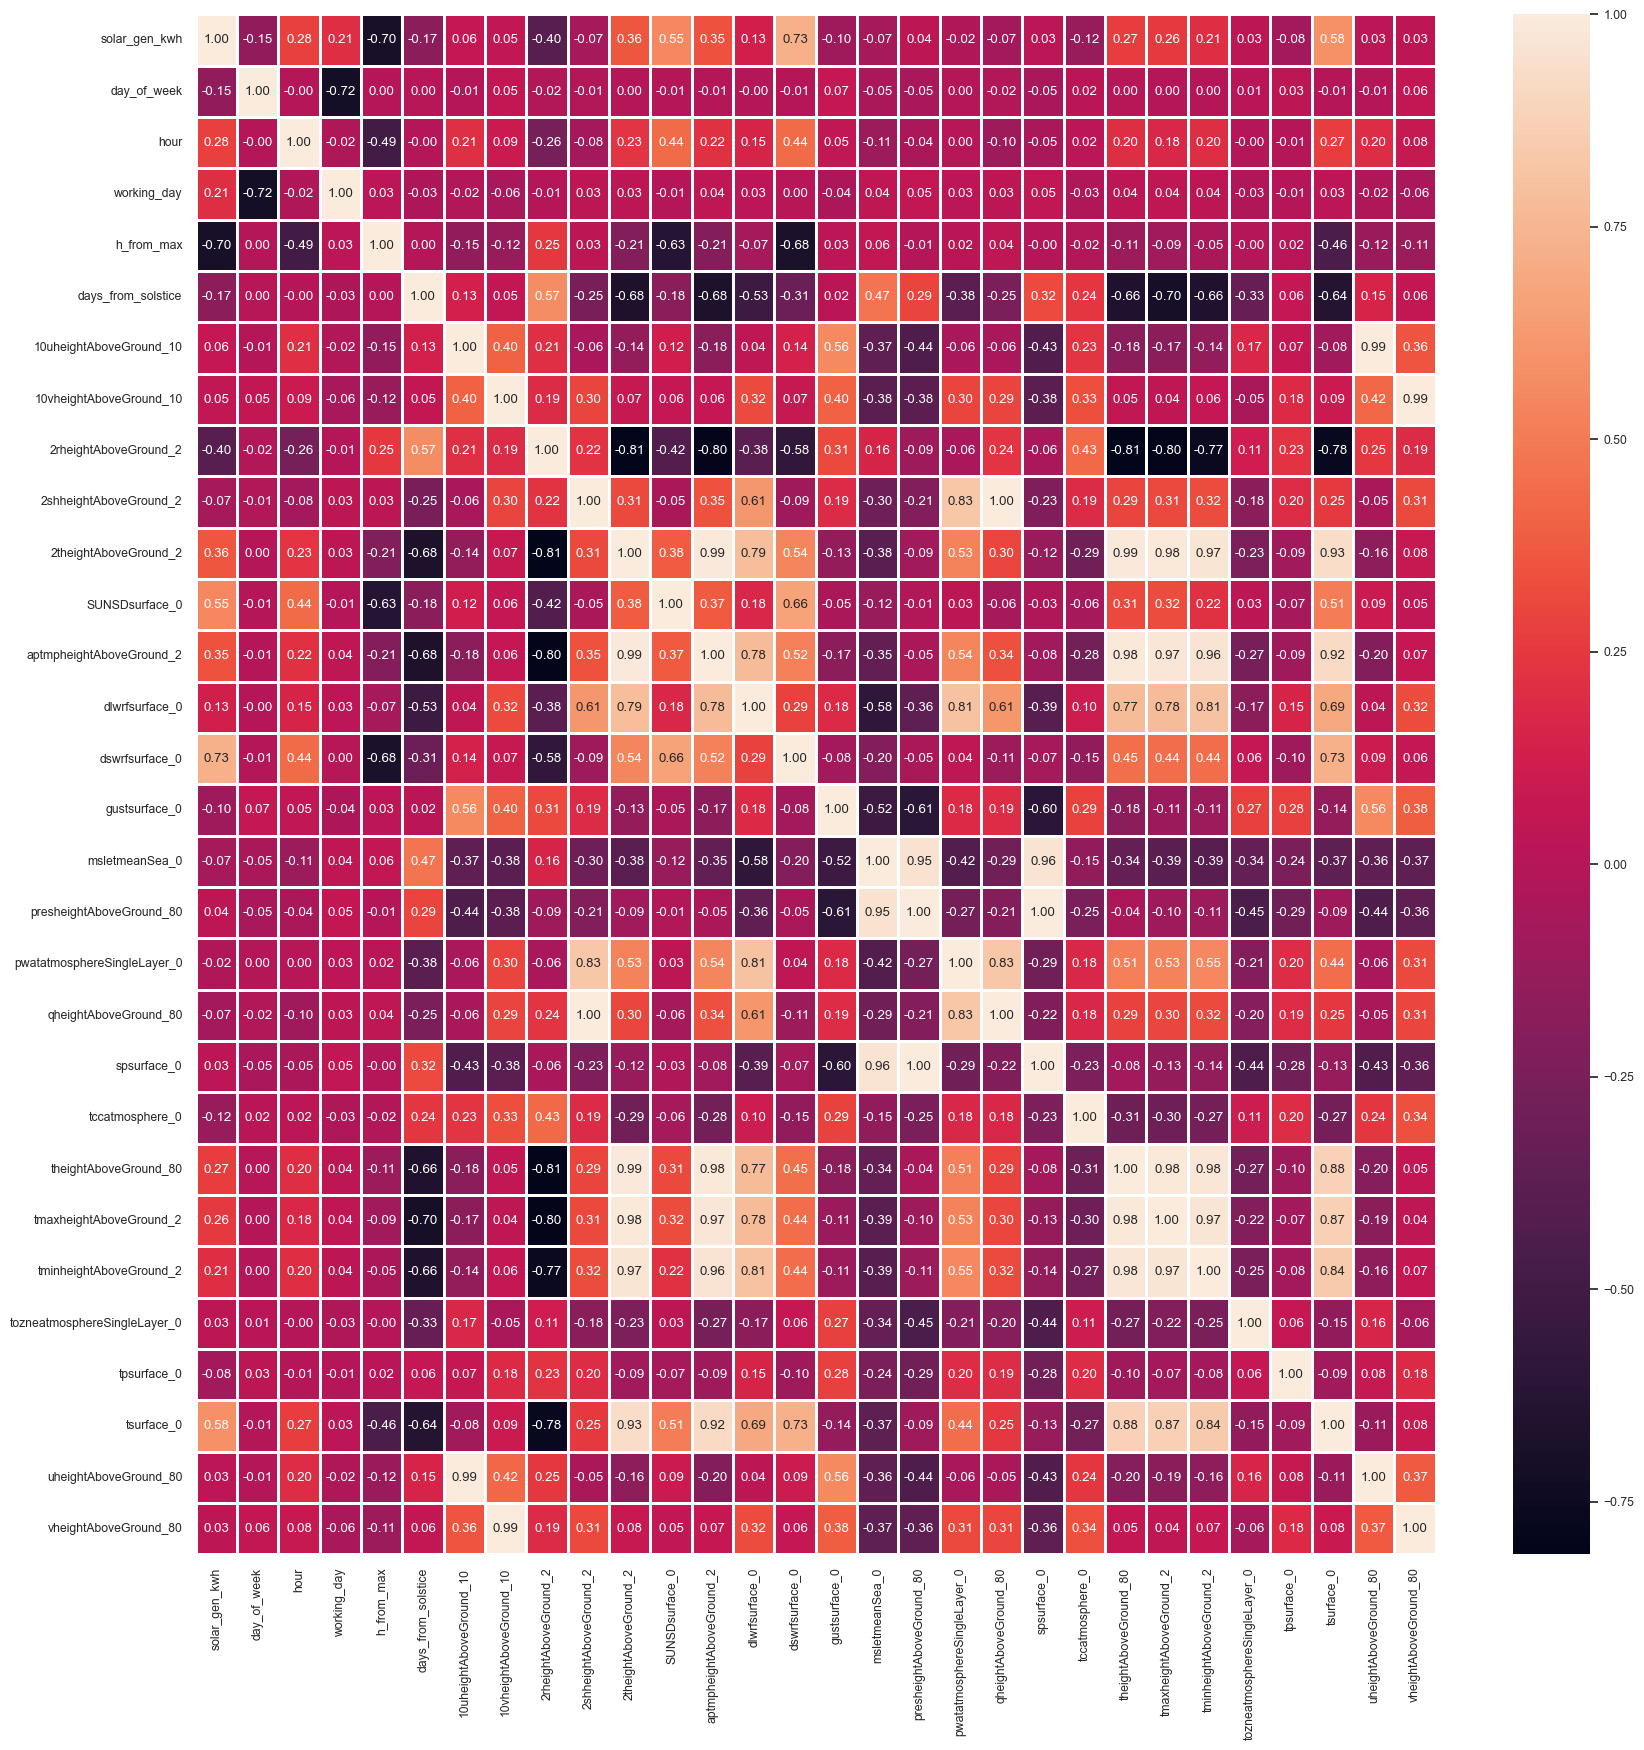

In [156]:
# and heatmap to show correlation between explanatory variables
sns.set(font_scale=0.8)
fig, ax = plt.subplots(figsize=(20,20))         
sns.heatmap(solar_weather.corr(), annot=True, fmt=".2f", linewidths=1, ax=ax)

### Forecasting Model


In [157]:
data = solar_weather.dropna(how='any')

In [172]:
data.iloc[:,0]

2023-07-24 13:00:00+02:00    129.98
2023-07-24 14:00:00+02:00    134.35
2023-07-24 15:00:00+02:00    133.90
2023-07-24 16:00:00+02:00    126.93
2023-07-24 17:00:00+02:00    121.22
                              ...  
2024-08-31 04:00:00+02:00      0.00
2024-08-31 05:00:00+02:00      0.00
2024-08-31 06:00:00+02:00      0.00
2024-08-31 07:00:00+02:00      0.00
2024-08-31 23:00:00+02:00      0.00
Name: solar_gen_kwh, Length: 8911, dtype: float64

In [185]:
# Separate features from response field
X, y = data.iloc[:,1:], data.iloc[:,0]
print(X.shape)
print(y.shape)

# Partition dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state= 123)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8911, 29)
(8911,)
(7128, 29)
(1783, 29)
(7128,)
(1783,)


In [186]:
params = {
    "n_estimators": 300,
    "max_depth": 6,
    "min_samples_split": 10,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

In [187]:
xgb = GradientBoostingRegressor(**params)
xgb.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=6, min_samples_split=10,
                          n_estimators=300)

In [188]:
mse = mean_squared_error(y_test, xgb.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 154.8370


In [195]:
import statsmodels.api as sm

model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:          solar_gen_kwh   R-squared (uncentered):                   0.812
Model:                            OLS   Adj. R-squared (uncentered):              0.811
Method:                 Least Squares   F-statistic:                              1056.
Date:                Tue, 25 Mar 2025   Prob (F-statistic):                        0.00
Time:                        18:45:09   Log-Likelihood:                         -31588.
No. Observations:                7128   AIC:                                  6.323e+04
Df Residuals:                    7099   BIC:                                  6.343e+04
Df Model:                          29                                                  
Covariance Type:            nonrobust                                                  
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

In [196]:
y_predictions =  results.predict(X_test)
print(y_predictions.shape)
mse_lr = mean_squared_error(y_test, y_predictions)
print("The mean squared error (MSE) on test set: {:.4f}".format(mse_lr))

(1783,)
The mean squared error (MSE) on test set: 439.2396


In [198]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

endog = y
exog = X
p = 0
d = 0
q = 1
P = 0
D = 0
Q = 1
s = 24


model = SARIMAX(endog, exog=exog, order=(p,d,q), seasonal_order=(P,D,Q,s), missin)
results = model.fit()

c:\Users\RUA\.conda\envs\data-science\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\RUA\.conda\envs\data-science\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


### Consumption

consumption_kwh    float64
dtype: object
                     consumption_kwh
date                                
2023-07-24 11:00:00       506.012634
2023-07-24 12:00:00       456.551453
2023-07-24 13:00:00       395.318604
2023-07-24 14:00:00       330.052979
2023-07-24 15:00:00       183.146606
consumption_kwh    0.001442
dtype: float64


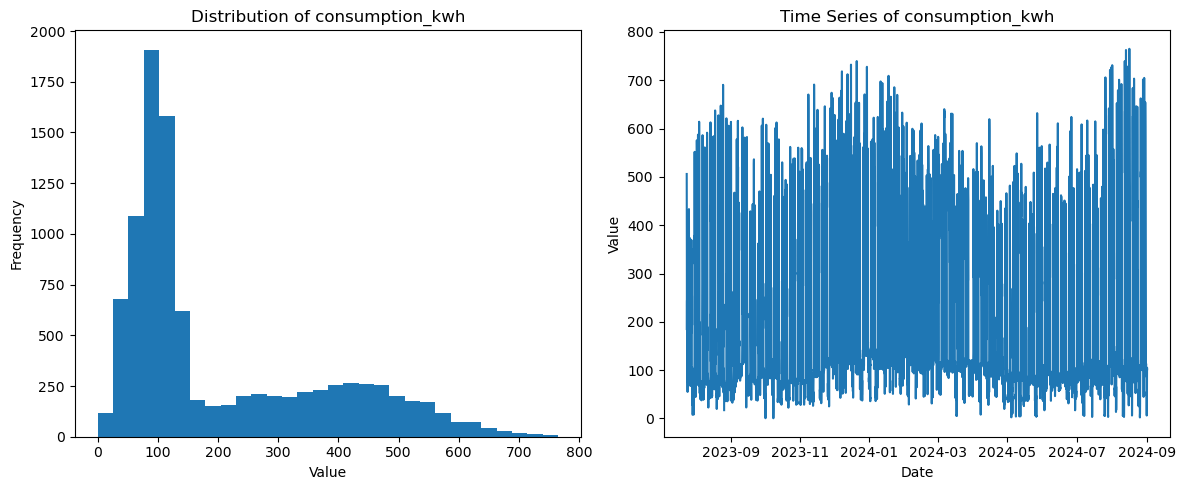

In [33]:
### Consumo. Date and Times are already in Madrid Local/Time.
consumption = pd.read_csv('data/raw/Consumo.csv')
consumption['date'] = pd.to_datetime(consumption['FECHA'])
consumption = consumption.set_index('date').drop(columns=['FECHA']).rename(columns={'TOTAL_KWH_ENERGIA': 'consumption_kwh'})
print(consumption.dtypes)
print(consumption.head())
print(consumption.isna().mean())
plot_eda(consumption, 'consumption_kwh')

solar_cons_kwh    float64
dtype: object
                           solar_cons_kwh
date                                     
2024-09-01 00:00:00+02:00             0.0
2024-09-01 01:00:00+02:00             0.0
2024-09-01 02:00:00+02:00             0.0
2024-09-01 03:00:00+02:00             0.0
2024-09-01 04:00:00+02:00             0.0


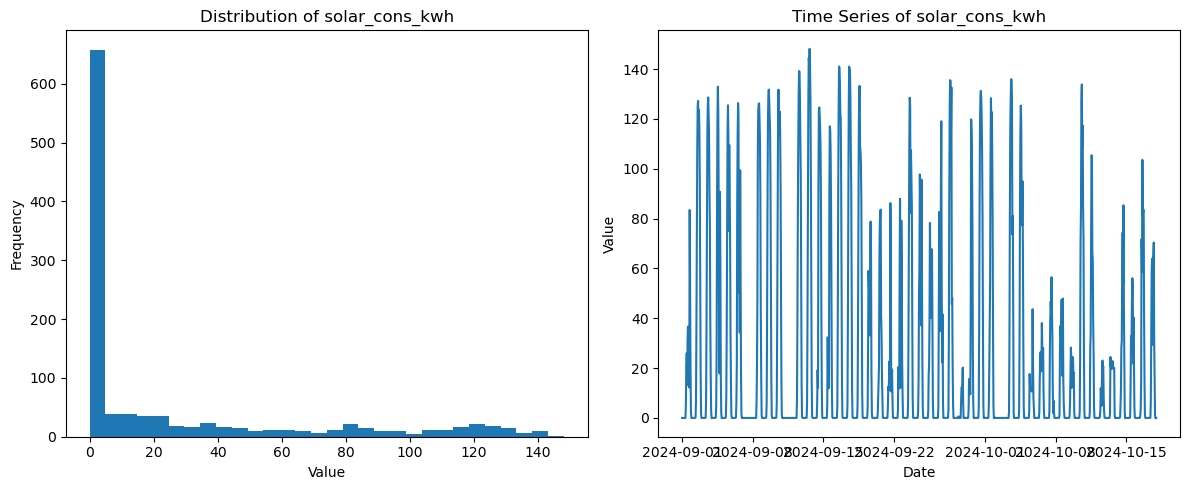

In [34]:
### Consumo Fotovoltaica. Date time in Europe/Madrid
solar_cons = pd.read_csv('data/raw/Consumo_fotovoltaica.csv')
solar_cons['date'] = pd.to_datetime(solar_cons['FECHA'])
solar_cons = solar_cons.set_index('date').drop(columns=['FECHA']).rename(columns={'TOTAL_KWH_ENERGIA': 'solar_cons_kwh'})
print(solar_cons.dtypes)
print(solar_cons.head())
plot_eda(solar_cons, 'solar_cons_kwh')

In [ ]:
### ES 2023- ES 2024. Date time in UTC.